In [ ]:
!pip install category_encoders


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from scipy import stats
from category_encoders import TargetEncoder
from sklearn.impute import SimpleImputer


In [ ]:
df = pd.read_csv('/content/ntrarogyaseva.csv')

In [ ]:
df = df.drop(['CLAIM_DATE','MORTALITY_DATE','DISCHARGE_DATE','   ','PREAUTH_DATE','SURGERY_DATE','SRC_REGISTRATION','CATEGORY_CODE','SURGERY_CODE','HOSP_DISTRICT','MANDAL_NAME','DISTRICT_NAME','CASTE_NAME'], axis=1)




In [ ]:
df.head()

,AGE,SEX,CATEGORY_NAME,SURGERY,VILLAGE,PREAUTH_AMT,CLAIM_AMOUNT,HOSP_NAME,HOSP_TYPE,HOSP_LOCATION,Mortality Y / N
0,56,Female,NEPHROLOGY,Maintenance Hemodialysis For Crf,Lolugu,12500,11000,"Rims Govt. General Hospital, Srikakulam",G,SRIKAKULAM,NO
1,37,Male,NEPHROLOGY,Maintenance Hemodialysis For Crf,Borivanka,12500,11000,"Rims Govt. General Hospital, Srikakulam",G,SRIKAKULAM,NO
2,50,Male,NEPHROLOGY,Maintenance Hemodialysis For Crf,Kapasakuddi,12500,11500,"Rims Govt. General Hospital, Srikakulam",G,SRIKAKULAM,NO
3,45,Male,NEPHROLOGY,Maintenance Hemodialysis For Crf,Telikipenta,12500,11000,"Rims Govt. General Hospital, Srikakulam",G,SRIKAKULAM,NO
4,54,Male,NEPHROLOGY,Maintenance Hemodialysis For Crf,Thandemvalasa,12500,11000,"Rims Govt. General Hospital, Srikakulam",G,SRIKAKULAM,NO


In [ ]:
df['SEX'] = df['SEX'].replace({'MALE': 'Male', 'FEMALE': 'Female'})


In [ ]:
df['CATEGORY_NAME'].unique()

array(['NEPHROLOGY', 'CARDIAC AND CARDIOTHORACIC SURGERY', 'CARDIOLOGY',
       'COCHLEAR IMPLANT SURGERY', 'ORTHOPEDIC  SURGERY AND PROCEDURES',
       'MEDICAL ONCOLOGY', 'PEDIATRICS',
       'GYNAECOLOGY AND OBSTETRICS  SURGERY', 'RADIATION ONCOLOGY',
       'GENITO URINARY SURGERIES', 'NEUROLOGY', 'POLY TRAUMA',
       'NEUROSURGERY', 'RHEUMATOLOGY', 'GENERAL SURGERY',
       'GASTROENTEROLOGY', 'PLASTIC SURGERY', 'OPHTHALMOLOGY  SURGERY',
       'PULMONOLOGY', 'GENERAL MEDICINE', 'CRITICAL CARE', 'ENT  SURGERY',
       'ENDOCRINOLOGY', 'SURGICAL ONCOLOGY', 'PEDIATRIC SURGERIES',
       'SURGICAL GASTRO ENTEROLOGY', 'DERMATOLOGY', 'PROSTHESES',
       'INFECTIOUS DISEASES'], dtype=object)

In [ ]:
# Preserve original categories before encoding
original_categories = df['CATEGORY_NAME'].copy()

# Initialize and fit the encoder
encoder = TargetEncoder(cols=['CATEGORY_NAME'], smoothing=10)
df['CATEGORY_NAME'] = encoder.fit_transform(df['CATEGORY_NAME'], df['CLAIM_AMOUNT'])

# Extract mapping and calculate frequencies from ORIGINAL data
category_mapping = encoder.mapping['CATEGORY_NAME']
freq_counts = original_categories.value_counts()

# Create mapping DataFrame
mapping_df = pd.DataFrame({
    'Original_Category': category_mapping.index,
    'Encoded_Value': category_mapping.values,
    'Frequency': freq_counts.reindex(category_mapping.index).fillna(0).astype(int).values
}).reset_index(drop=True)

# Save mapping
mapping_df.to_csv('category_mapping.csv', index=False)


In [ ]:
df.head()

,AGE,SEX,CATEGORY_NAME,SURGERY,VILLAGE,PREAUTH_AMT,CLAIM_AMOUNT,HOSP_NAME,HOSP_TYPE,HOSP_LOCATION,Mortality Y / N
0,56,Female,13524.963628,Maintenance Hemodialysis For Crf,Lolugu,12500,11000,"Rims Govt. General Hospital, Srikakulam",G,SRIKAKULAM,NO
1,37,Male,13524.963628,Maintenance Hemodialysis For Crf,Borivanka,12500,11000,"Rims Govt. General Hospital, Srikakulam",G,SRIKAKULAM,NO
2,50,Male,13524.963628,Maintenance Hemodialysis For Crf,Kapasakuddi,12500,11500,"Rims Govt. General Hospital, Srikakulam",G,SRIKAKULAM,NO
3,45,Male,13524.963628,Maintenance Hemodialysis For Crf,Telikipenta,12500,11000,"Rims Govt. General Hospital, Srikakulam",G,SRIKAKULAM,NO
4,54,Male,13524.963628,Maintenance Hemodialysis For Crf,Thandemvalasa,12500,11000,"Rims Govt. General Hospital, Srikakulam",G,SRIKAKULAM,NO


In [ ]:

# Encode 'Mortality Y / N' column
df['Mortality Y / N'] = df['Mortality Y / N'].map({'YES': 1, 'NO': 0})


In [ ]:
df['SEX'].unique()

array(['Female', 'Male', 'Male(Child)', 'Female(Child)'], dtype=object)

In [ ]:

# Create a mapping for the 'SEX' column
sex_mapping = {
    'Female': 0,
    'Male': 1,
    'Male(Child)': 2,
    'Female(Child)': 3
}

# Apply the mapping to the 'SEX' column
df['SEX'] = df['SEX'].map(sex_mapping)

df['SEX'].unique()


array([0, 1, 2, 3])

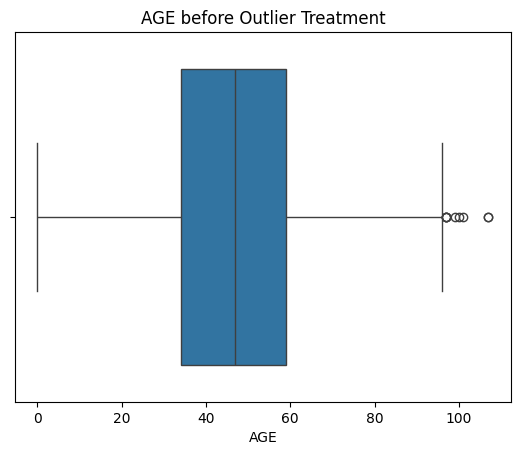

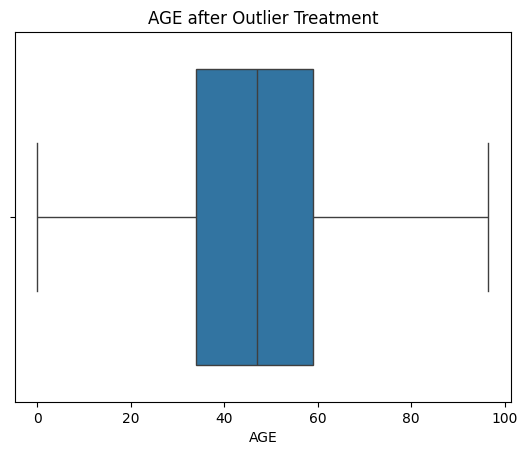

Skewness of AGE: -0.5743356176925238


In [ ]:
sns.boxplot(x=df['AGE'])
plt.title('AGE before Outlier Treatment')
plt.show()

Q1 = df['AGE'].quantile(0.25)
Q3 = df['AGE'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Cap outliers at lower and upper bounds
df['AGE'] = df['AGE'].clip(lower=lower_bound, upper=upper_bound)

# Optional visualization after capping outliers
sns.boxplot(x=df['AGE'])
plt.title('AGE after Outlier Treatment')
plt.show()

skewness_age = df['AGE'].skew()
print("Skewness of AGE:", skewness_age)

# Normalize 'AGE'
scaler_age = MinMaxScaler()
df['AGE'] = scaler_age.fit_transform(df[['AGE']])


In [ ]:
df.head()

,AGE,SEX,CATEGORY_NAME,SURGERY,VILLAGE,PREAUTH_AMT,CLAIM_AMOUNT,HOSP_NAME,HOSP_TYPE,HOSP_LOCATION,Mortality Y / N
0,0.580311,0,13524.963628,Maintenance Hemodialysis For Crf,Lolugu,12500,11000,"Rims Govt. General Hospital, Srikakulam",G,SRIKAKULAM,0
1,0.383420,1,13524.963628,Maintenance Hemodialysis For Crf,Borivanka,12500,11000,"Rims Govt. General Hospital, Srikakulam",G,SRIKAKULAM,0
2,0.518135,1,13524.963628,Maintenance Hemodialysis For Crf,Kapasakuddi,12500,11500,"Rims Govt. General Hospital, Srikakulam",G,SRIKAKULAM,0
3,0.466321,1,13524.963628,Maintenance Hemodialysis For Crf,Telikipenta,12500,11000,"Rims Govt. General Hospital, Srikakulam",G,SRIKAKULAM,0
4,0.559585,1,13524.963628,Maintenance Hemodialysis For Crf,Thandemvalasa,12500,11000,"Rims Govt. General Hospital, Srikakulam",G,SRIKAKULAM,0


In [ ]:
df['SURGERY'].unique()

array(['Maintenance Hemodialysis For Crf',
       'Coronary Balloon Angioplasty with stent(00.45)',
       'Coronary Bypass Surgery', 'Management Of Acute MI With Angiogram',
       'Medical Management of  Refractory Cardiac Failure',
       'Cochlear Implant Surgery',
       'Excision Or Other Operations For Scaphoid Fractures',
       'Chemotherapy for Acute Myeloid Leukemia with Induction Phase',
       'Ablation Therapy for Simple Arrythmias',
       'PTCA 1 Additional Stent (00.46)',
       'Patent Ductus Arterious - Device Closure',
       'Mitral Valve Replacement (With Valve)',
       'Coronary Balloon Angioplasty with Drug eluting stent(00.45)',
       'Medical Management of Term Baby With Severe Perinatal Asphyxia Clinically evident septicemia, Hyperbilirubinem ia - Not requiring Ventilatory support.',
       'Arthroscopy . Operative Meniscectomy',
       'Anterior cruciate ligamentl reconstruction',
       'Vaginal Hysterectomy With Pelvic Floor Repair(70.79)',
       'Lapro

In [ ]:

# Preserve original values before encoding
original_surgeries = df['SURGERY'].copy()

# Initialize and fit encoder
encoder = TargetEncoder(cols=['SURGERY'], smoothing=10)
df['SURGERY'] = encoder.fit_transform(df['SURGERY'], df['CLAIM_AMOUNT'])

# Get frequency counts (properly aligned)
value_counts = original_surgeries.value_counts()

# Create mapping table with safe reindexing
surgery_mapping = pd.DataFrame({
    'Original_Surgery': encoder.mapping['SURGERY'].index,
    'Encoded_Value': encoder.mapping['SURGERY'].values,
    'Frequency': value_counts.reindex(encoder.mapping['SURGERY'].index)
                            .fillna(0)
                            .astype(int)
                            .values
}).reset_index(drop=True)

surgery_mapping.to_csv('surgery_mapping.csv', index=False)
print(surgery_mapping.head())


   Original_Surgery  Encoded_Value  Frequency
0                 1   11732.325951          0
1                 2   55297.619115          0
2                 3  116598.374981          0
3                 4   24785.199269          0
4                 5   30566.484463          0


In [ ]:
village=df['VILLAGE'].unique()
print(village)

['Lolugu' 'Borivanka' 'Kapasakuddi' ... 'G.Palavalasa@T.V.P.Vala'
 'Boithala' 'Koturupalle']


In [ ]:
with open('unique_villages.txt', 'w') as f:
    for value in village:
        f.write(str(value) + '\n')


In [ ]:
# Preserve original data BEFORE encoding
original_villages = df['VILLAGE'].copy()

# Initialize and fit encoder
encoder = TargetEncoder(cols=['VILLAGE'], smoothing=20)
df['VILLAGE'] = encoder.fit_transform(df['VILLAGE'], df['CLAIM_AMOUNT'])

# Get frequency counts from ORIGINAL data (pre-encoding)
village_counts = original_villages.value_counts()

# Create mapping with PROPER index alignment
village_mapping = pd.DataFrame({
    'Original_Village': encoder.mapping['VILLAGE'].index,
    'Encoded_Value': encoder.mapping['VILLAGE'].values,
    'Frequency': village_counts.reindex(encoder.mapping['VILLAGE'].index)
                              .fillna(0)  # Handle missing villages
                              .astype(int)
                              .values
}).reset_index(drop=True)

# Save mapping
village_mapping.to_csv('village_encoding.csv', index=False)


In [ ]:
df['HOSP_NAME'].unique()

array(['Rims Govt. General Hospital, Srikakulam',
       'Govt General Hospital Kurnool', 'Queens Nri Hospitals',
       'Karumuri Hospital', 'Ent Nursing Home',
       'KIMS SAI SESHDRI HOSPITAL', 'Nims Hospitals',
       'Govt Ent Hospital  - Koti', 'OZONE HOSPITALS',
       'Area Hospital - Cheerala', '7 STAR SUPER SPECIALITY HOSPITAL',
       'ABHIRAM INSTITUTE OF MEDICAL SCIENCES',
       'MyCure HospitalsA Unit of Sahrudaya Helath Care Private Limited',
       'Apollo Hospitals Enterprises Ltd Jubilee Hills',
       'Aswini Hospital',
       'BASAVATARAKAM INDO AMERICAN CANCER HOSPITAL and RESEARCH INSTITUTE, Hyderabad',
       'SAILAJA MULTISPECIALITY HOSPITAL',
       'Andhra Health Diagnostic Services LimitedGlobal Vijayawada',
       'Government General Hospital,Kakinada',
       'Ms Mahatma Gandhi Cancer Hospital and Research Institute',
       'King George Hospital', 'Rims General Hospital',
       'Area Hospital - Madanapalli', 'S.V.R.R.Hospital',
       'SURYA GLOBAL MULT

In [ ]:

# Initialize encoder with regularization
encoder = TargetEncoder(cols=['HOSP_NAME'], smoothing=10)

# Fit-transform while preserving original data relationships
df['HOSP_NAME'] = encoder.fit_transform(df['HOSP_NAME'], df['CLAIM_AMOUNT'])

# Create mapping reference table
hosp_mapping = pd.DataFrame({
    'Original_Hospital': encoder.mapping['HOSP_NAME'].index,
    'Encoded_Value': encoder.mapping['HOSP_NAME'].values
}).reset_index(drop=True)

hosp_mapping.to_csv('hospital_encoding_mapping.csv', index=False)


In [ ]:
# Overwrite HOSP_TYPE with binary encoding
df['HOSP_TYPE'] = df['HOSP_TYPE'].map({'G': 0, 'C': 1})

# Verify
print(df['HOSP_TYPE'].unique())  # Output: [0, 1]


[0 1]


In [ ]:
df['HOSP_LOCATION'].unique()

array(['SRIKAKULAM', 'KURNOOL', 'Visakhapatnam', 'GUNTUR', 'HYDERABAD',
       'CHEERALA', 'KAKINADA', 'NELLORE', 'VISAKHAPATNAM', 'VIJAYAWADA',
       'KADAPA', 'Chittoor', 'TIRUPATHI', 'VIZIANAGARAM', 'ONGOLE',
       'ANANTAPUR', 'Kurnool', 'CHITTOOR', 'BHIMAVARAM', 'YSR',
       'Hyderabad', 'Ongole', 'RAJAHMUNDRY', 'Guntur', 'TANUKU', 'ELURU',
       'NARSARAOPET', 'RANGAREDDY', 'MACHILIPATNAM', 'SECUNDERABAD',
       'KHAMMAM', 'ANAKAPALLI', 'WEST GODAVARI', 'Vizianagaram',
       'PALAKOLLU', 'KUPPAM', 'EAST GODAVARI', 'TENALI',
       'RAMACHANDRAPURAM', 'NANDYALA', 'KADIRI', 'Tirupathi',
       'AMALAPURAM', 'WARANGAL', 'MADANAPALLI', 'MEHEDIPATNAM',
       'TADEPALLI GUDEM', 'Tadepalli Gudem', 'PRAKASHAM', 'BHADRACHALAM',
       'Kakinada', 'KARIMNAGAR', 'NIZAMABAD', 'GUDIVADA', 'MANDAPETA',
       'Rajahmundry', 'MAHBUBNAGAR', 'JANGAREDDY GUDEM', 'KAMAREDDY',
       'Ongole ', 'Vijayawada'], dtype=object)

In [ ]:
# Clean text and standardize casing
df['HOSP_LOCATION'] = df['HOSP_LOCATION'].str.strip().str.upper()

# Fix known inconsistencies
location_mapping = {
    'VISAKHAPATNAM': 'VISAKHAPATNAM',  # Merge duplicates
    'TIRUPATHI': 'TIRUPATI',           # Common misspellings
    'TADEPALLI GUDEM': 'TADEPALLIGUDEM',
    'VIZIANAGARAM': 'VIZIANAGARAM',
    'YSR': 'Y.S.R. KADAPA',
    'Vijayawada': 'VIJAYAWADA',        # Case correction
    'Kurnool': 'KURNOOL',
    'Ongole ': 'ONGOLE'                # Remove trailing space
}

df['HOSP_LOCATION'] = df['HOSP_LOCATION'].map(location_mapping).fillna(df['HOSP_LOCATION'])
# Initialize encoder with smoothing
encoder = TargetEncoder(
    cols=['HOSP_LOCATION'],
    smoothing=8,  # Adjust based on data size (8-15 for healthcare data)
    min_samples_leaf=5
)

# Fit-transform
df['HOSP_LOCATION'] = encoder.fit_transform(df['HOSP_LOCATION'], df['CLAIM_AMOUNT'])

# Build traceability table
location_mapping = pd.DataFrame({
    'Original_Location': encoder.mapping['HOSP_LOCATION'].index,
    'Encoded_Value': encoder.mapping['HOSP_LOCATION'].values,
    'Frequency': df['HOSP_LOCATION'].value_counts().reindex(encoder.mapping['HOSP_LOCATION'].index).values
}).reset_index(drop=True)

location_mapping.to_csv('hospital_location_mapping.csv', index=False)


In [ ]:
df.head()

,AGE,SEX,CATEGORY_NAME,SURGERY,VILLAGE,PREAUTH_AMT,CLAIM_AMOUNT,HOSP_NAME,HOSP_TYPE,HOSP_LOCATION,Mortality Y / N
0,0.580311,0,13524.963628,11732.325951,28220.363970,12500,11000,17402.00927,0,24879.964739,0
1,0.383420,1,13524.963628,11732.325951,21412.152698,12500,11000,17402.00927,0,24879.964739,0
2,0.518135,1,13524.963628,11732.325951,28088.496281,12500,11500,17402.00927,0,24879.964739,0
3,0.466321,1,13524.963628,11732.325951,26112.027790,12500,11000,17402.00927,0,24879.964739,0
4,0.559585,1,13524.963628,11732.325951,24983.685639,12500,11000,17402.00927,0,24879.964739,0


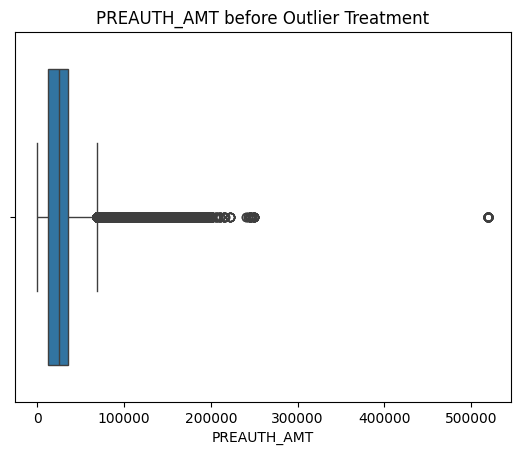

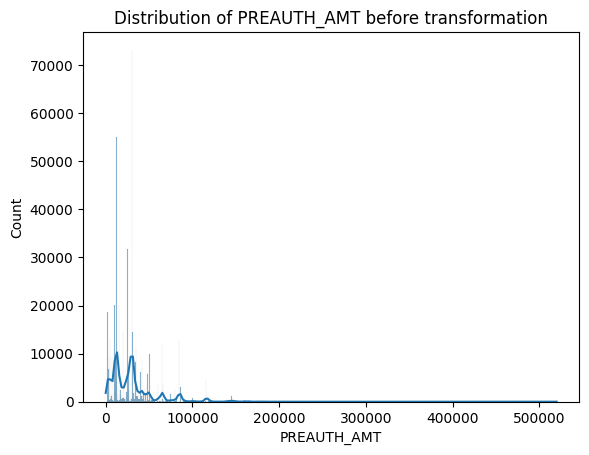

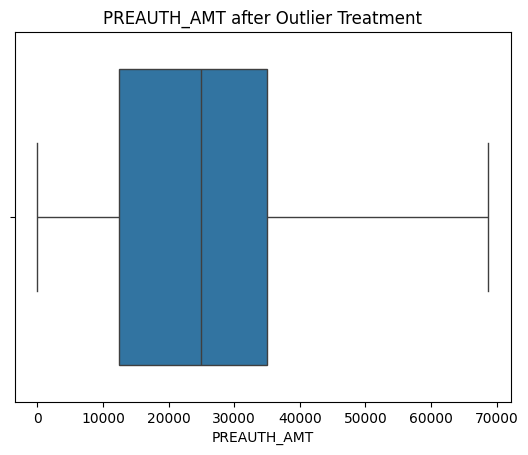

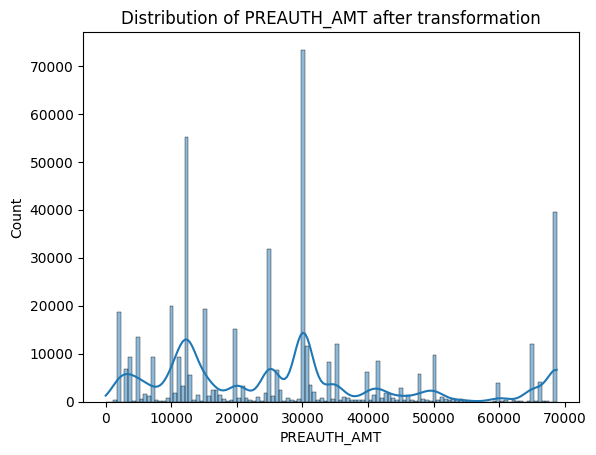

Skewness: 0.8111688620117489


In [ ]:
sns.boxplot(x=df['PREAUTH_AMT'])
plt.title('PREAUTH_AMT before Outlier Treatment')
plt.show()

sns.histplot(df['PREAUTH_AMT'], kde=True)
plt.title('Distribution of PREAUTH_AMT before transformation')
plt.show()


Q1 = df['PREAUTH_AMT'].quantile(0.25)
Q3 = df['PREAUTH_AMT'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df['PREAUTH_AMT'] = df['PREAUTH_AMT'].clip(lower=lower_bound, upper=upper_bound)

sns.boxplot(x=df['PREAUTH_AMT'])
plt.title('PREAUTH_AMT after Outlier Treatment')
plt.show()

sns.histplot(df['PREAUTH_AMT'], kde=True)
plt.title('Distribution of PREAUTH_AMT after transformation')
plt.show()

skewness = df['PREAUTH_AMT'].skew()
print(f"Skewness: {skewness}")

# Normalize 'PREAUTH_AMT'
scaler_claim = MinMaxScaler()
df['PREAUTH_AMT'] = scaler_claim.fit_transform(df[['PREAUTH_AMT']])


In [ ]:
df.head()

,AGE,SEX,CATEGORY_NAME,SURGERY,VILLAGE,PREAUTH_AMT,CLAIM_AMOUNT,HOSP_NAME,HOSP_TYPE,HOSP_LOCATION,Mortality Y / N
0,0.580311,0,13524.963628,11732.325951,28220.363970,0.181759,11000,17402.00927,0,24879.964739,0
1,0.383420,1,13524.963628,11732.325951,21412.152698,0.181759,11000,17402.00927,0,24879.964739,0
2,0.518135,1,13524.963628,11732.325951,28088.496281,0.181759,11500,17402.00927,0,24879.964739,0
3,0.466321,1,13524.963628,11732.325951,26112.027790,0.181759,11000,17402.00927,0,24879.964739,0
4,0.559585,1,13524.963628,11732.325951,24983.685639,0.181759,11000,17402.00927,0,24879.964739,0


In [ ]:
df.columns

Index(['AGE', 'SEX', 'CATEGORY_NAME', 'SURGERY', 'VILLAGE', 'PREAUTH_AMT',
       'CLAIM_AMOUNT', 'HOSP_NAME', 'HOSP_TYPE', 'HOSP_LOCATION',
       'Mortality Y / N'],
      dtype='object')

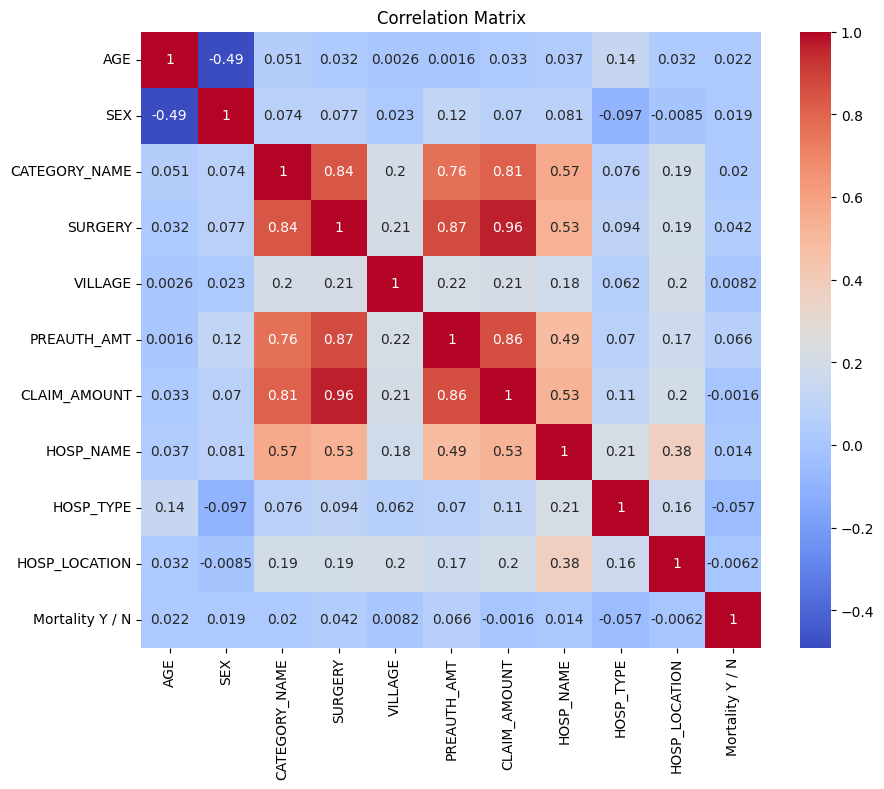

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


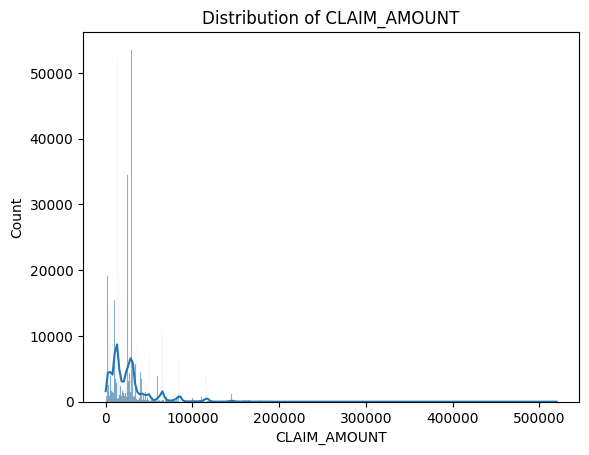

In [ ]:
sns.histplot(df['CLAIM_AMOUNT'], kde=True)
plt.title('Distribution of CLAIM_AMOUNT')
plt.show()


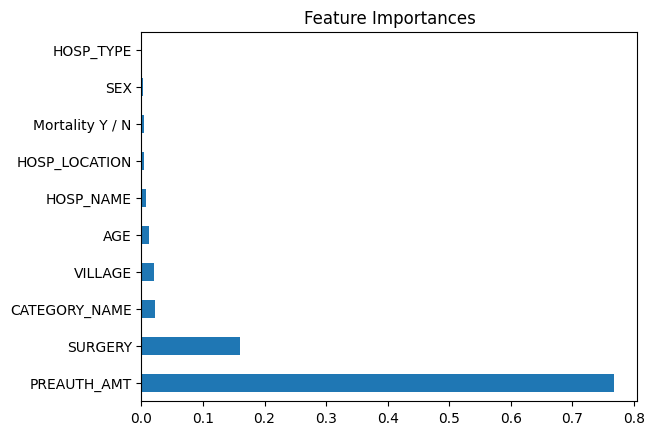

In [ ]:
from sklearn.ensemble import RandomForestRegressor

X = df.drop('CLAIM_AMOUNT', axis=1)
y = df['CLAIM_AMOUNT']

rf = RandomForestRegressor(random_state=42)
rf.fit(X, y)

feature_importances = pd.Series(rf.feature_importances_, index=X.columns)
feature_importances.sort_values(ascending=False).plot.barh()
plt.title('Feature Importances')
plt.show()


In [ ]:
# Save the processed DataFrame to a CSV file
df.to_csv('processed_data.csv', index=False)
